* Gabriel Palace Novaes Henrique - RA 202310491
* João Vítor Albergaria Barbosa - RA 202310501

NÃO APAGAR
https://wandb.ai/joaoalbergaria-facamp-ia/YOLOv5/runs/ficrkyom?nw=nwuserjoaoalbergariafacamp

NÃO APAGAR https://wandb.ai/joaoalbergaria-facamp-ia/YOLOv5/runs/3abx2lf5/workspace?nw=nwuserjoaoalbergariafacamp

# 1. Entendimento do negócio

Os sistemas de reconhecimento facial são tecnologias que utilizam IA para identificar ou verificar a identidade de uma pessoa a partir de características faciais. Eles funcionam por meio da análise de imagens capturadas por câmeras e a comparação com dados armazenados em bancos de dados.

Sua importância tem crescido em diversas áreas, como segurança pública, controle de acesso, autenticação em dispositivos eletrônicos e monitoramento em tempo real. Além de aumentar a eficiência e a precisão na identificação de indivíduos, esses sistemas também ajudam a prevenir fraudes, reforçar a proteção de dados e agilizar processos em ambientes corporativos e governamentais.

Neste notebook, está descrita uma implementação de detecção facial utilizando o modelo de detecção de objetos YOLOv5, da Ultralytics. Ele é uma solução de deep learning open-source, sob a *GNU AFFERO GENERAL PUBLIC LICENSE*, disponibilizado em um [repositório no GitHub](https://https://github.com/ultralytics/yolov5).  

Foram, para este notebook, adaptadas e seguidas as etapas delineadas no roteiro visto em aula:
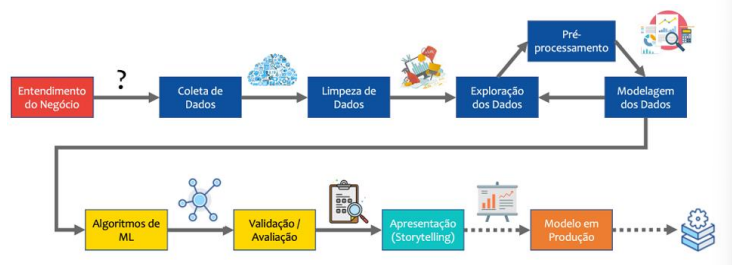

# 2. Coleta de dados

Para a composição do dataset, foram utilizadas duas fontes:
fotos dos rostos dos autores, e uma base de dados de imagens encontrada no Kaggle. O processo de coleta será discorrido nos tópicos seguintes.


In [ ]:
# Remover as pastas, se necessário
# !rm -rf /content/dataset
#!rm -rf /content/yolov5

'rm' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


## 2.1. Fotos dos rostos dos autores

Foram feitas imagens com diferentes expressões, ângulos e fundos a fim de que o modelo fosse capaz de identificar com maior precisão as faces.

Conforme o modelo de dataset usado pelo YOLO, temos:

```
dataset/
├── images/
│   ├── train/
│   └── val/     
└── labels/
    ├── train/
    └── val/
```

As fotos foram, deste modo, colocadas na pasta images e organizadas com uma proporção 80:20 entre treino e validação (pastas train e val)

Porém, ainda faltava um ponto fundamental: a rotulação desses arquivos.

Após muitas pesquisas, o grupo descobriu um software chamado *labelImg*, uma ferramenta open-source que auxilia na classificação dessas imagens por meio de retângulos, que são diretamente convertidos em arquivos .txt com suas respectivas coordenadas:

```
1 0.469583 0.545937 0.435833 0.385625
```

`<índice da classe> <x_centro> <y_centro> <largura> <altura>`

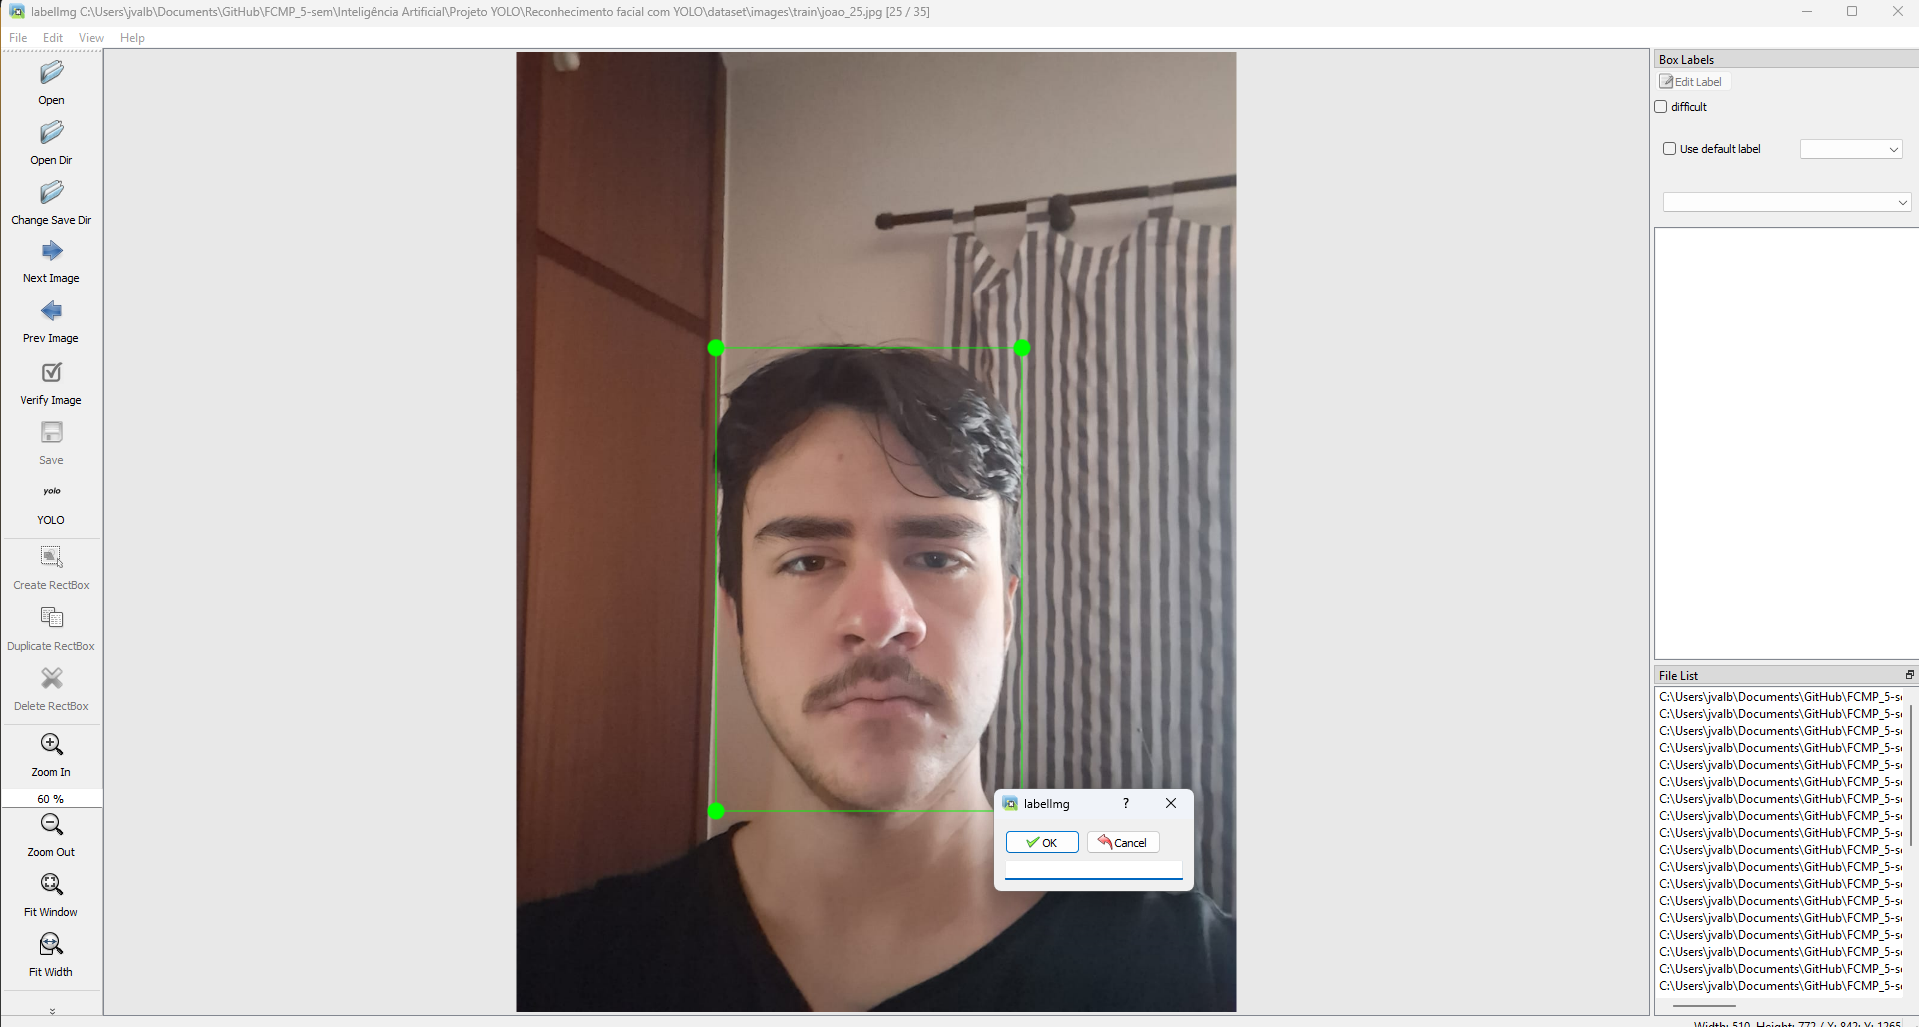


Segue o vídeo que ajudou a dupla a instalar e utilizar o software:

[How to use LabelImg for Data Annotation and use it in Ultralytics HUB | Episode 64](https://youtu.be/pTJT8kKi9SM)

Após realizar a rotulação das imagens, o dataset foi comprimido em um arquivo .zip, e extraído de dentro do Colab (para que pudesse ser feito o upload de uma vez só)

In [ ]:
!unzip /content/dataset.zip -d /content/

Archive:  /content/dataset.zip
   creating: /content/dataset/
   creating: /content/dataset/images/
   creating: /content/dataset/images/train/
  inflating: /content/dataset/images/train/joao_1.jpg  
  inflating: /content/dataset/images/train/joao_10.jpg  
  inflating: /content/dataset/images/train/joao_11.jpg  
  inflating: /content/dataset/images/train/joao_12.jpg  
  inflating: /content/dataset/images/train/joao_13.jpg  
  inflating: /content/dataset/images/train/joao_14.jpg  
  inflating: /content/dataset/images/train/joao_15.jpg  
  inflating: /content/dataset/images/train/joao_16.jpg  
  inflating: /content/dataset/images/train/joao_17.jpg  
  inflating: /content/dataset/images/train/joao_18.jpg  
  inflating: /content/dataset/images/train/joao_19.jpg  
  inflating: /content/dataset/images/train/joao_2.jpg  
  inflating: /content/dataset/images/train/joao_20.jpg  
  inflating: /content/dataset/images/train/joao_21.jpg  
  inflating: /content/dataset/images/train/joao_22.jpg  
  i

### 2.1.1. Tratamento das imagens

Como era inviável fazer centenas de imagens, foi utilizado um mecanismo em código para gerar cópias das imagens levemente alteradas aleatoriamentee no que se refere a contraste, brilho e rotação, por exemplo

In [ ]:
import cv2
import os
import albumentations as A
import uuid
from pathlib import Path

augment = A.Compose([
    A.RandomBrightnessContrast(p=0.7),
    A.Rotate(limit=25, p=0.7),
    A.RandomScale(scale_limit=0.2, p=0.7),
    A.MotionBlur(blur_limit=5, p=0.3),
    A.ColorJitter(p=0.5),
    A.RandomShadow(p=0.3),
    A.RandomFog(p=0.2),
])

qtt = len(os.listdir('/content/dataset/images/train'))

input_folder = "/content/dataset/images/train"
output_folder = "/content/dataset/images/train"

labels_dir = Path('/content/dataset/labels/train')

os.makedirs(output_folder, exist_ok=True)
print(os.listdir(input_folder))
for filename in os.listdir(input_folder):
    if not (filename.endswith(".jpg") or filename.endswith(".jpeg")):
        continue

    print(filename)
    image_path = os.path.join(input_folder, filename)
    image = cv2.imread(image_path)

    label_filename = filename.replace('.jpg', '.txt').replace('.jpeg', '.txt')
    old_label_path = labels_dir / label_filename
    print(old_label_path)
    for i in range(6):  # Quantas cópias modificadas eu vou querer de cada imagem.
        qtt += 1
        augmented = augment(image=image)["image"]
        if (filename.startswith('joao_')):
            out_name = f"joao_{qtt}.jpg"
            class_id = 1
        elif (filename.startswith('gabriel_')):
            out_name = f"gabriel_{qtt}.jpg"
            class_id = 2
        cv2.imwrite(os.path.join(output_folder, out_name), augmented)

        with open(old_label_path, "r") as f:
            txt = f.read()
        new_label_path = labels_dir / out_name.replace('.jpg', '.txt').replace('.jpeg', '.txt')

        with open(new_label_path, "w") as f:
            f.write(txt)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


['joao_26.jpg', 'joao_7.jpg', 'joao_15.jpg', 'joao_1.jpg', 'joao_17.jpg', 'joao_12.jpg', 'joao_14.jpg', 'joao_18.jpg', 'joao_31.jpg', 'joao_28.jpg', 'joao_4.jpg', 'joao_19.jpg', 'joao_23.jpg', 'joao_34.jpg', 'joao_2.jpg', 'joao_10.jpg', 'joao_29.jpg', 'joao_3.jpg', 'joao_5.jpg', 'joao_8.jpg', 'joao_6.jpg', 'joao_35.jpg', 'joao_24.jpg', 'joao_11.jpg', 'joao_21.jpg', 'joao_27.jpg', 'joao_22.jpg', 'joao_20.jpg', 'joao_16.jpg', 'joao_25.jpg', 'joao_9.jpg', 'joao_33.jpg', 'joao_13.jpg', 'joao_30.jpg', 'joao_32.jpg']
joao_26.jpg
/content/dataset/labels/train/joao_26.txt
joao_7.jpg
/content/dataset/labels/train/joao_7.txt
joao_15.jpg
/content/dataset/labels/train/joao_15.txt
joao_1.jpg
/content/dataset/labels/train/joao_1.txt
joao_17.jpg
/content/dataset/labels/train/joao_17.txt
joao_12.jpg
/content/dataset/labels/train/joao_12.txt
joao_14.jpg
/content/dataset/labels/train/joao_14.txt
joao_18.jpg
/content/dataset/labels/train/joao_18.txt
joao_31.jpg
/content/dataset/labels/train/joao_31.txt
j

In [ ]:
import cv2
import os
import albumentations as A
import uuid
from pathlib import Path

augment = A.Compose([
    A.RandomBrightnessContrast(p=0.7),
    A.Rotate(limit=25, p=0.7),
    A.RandomScale(scale_limit=0.2, p=0.7),
    A.MotionBlur(blur_limit=5, p=0.3),
    A.ColorJitter(p=0.5),
    A.RandomShadow(p=0.3),
    A.RandomFog(p=0.2),
])

qtt = len(os.listdir('/content/dataset/images/val'))

input_folder = "/content/dataset/images/val"
output_folder = "/content/dataset/images/val"

labels_dir = Path('/content/dataset/labels/val')

os.makedirs(output_folder, exist_ok=True)
print(os.listdir(input_folder))
for filename in os.listdir(input_folder):
    if not (filename.endswith(".jpg") or filename.endswith(".jpeg")):
        continue

    print(filename)
    image_path = os.path.join(input_folder, filename)
    image = cv2.imread(image_path)

    label_filename = filename.replace('.jpg', '.txt').replace('.jpeg', '.txt')
    old_label_path = labels_dir / label_filename
    print(old_label_path)
    for i in range(6):  # Quantas cópias modificadas eu vou querer de cada imagem.
        qtt += 1
        augmented = augment(image=image)["image"]
        if (filename.startswith('joao_')):
            out_name = f"joao_{qtt}.jpg"
            class_id = 1
        elif (filename.startswith('gabriel_')):
            out_name = f"gabriel_{qtt}.jpg"
            class_id = 2
        cv2.imwrite(os.path.join(output_folder, out_name), augmented)

        with open(old_label_path, "r") as f:
            txt = f.read()
        new_label_path = labels_dir / out_name.replace('.jpg', '.txt').replace('.jpeg', '.txt')

        with open(new_label_path, "w") as f:
            f.write(txt)

## 2.2. Importação de um dataset de dados

Para tornar nossa base de dados mais robusta, o grupo optou por utilizar um dataset disponibilizado pelo usuário *sbaghbidi*, que tem mais de 2000 imagens e um arquivo .csv com as coordenadas (em pixels) das bounding boxes para rotular as faces.


https://www.kaggle.com/datasets/sbaghbidi/human-faces-object-detection

Contudo, em vez de fazer o download e fazer o upload para o Colab, preferimos fazer isso através do Python, o que facilita muito a portabilidade deste notebook.

In [ ]:
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("sbaghbidi/human-faces-object-detection")

print("Path:", path)
print("Subfolders:", os.listdir(path))

100%|██████████| 498M/498M [00:06<00:00, 76.8MB/s]

Extracting files...


Path: /root/.cache/kagglehub/datasets/sbaghbidi/human-faces-object-detection/versions/1
Subfolders: ['images', 'faces.csv']


In [ ]:
# import shutil

# img_path = os.path.join(path, "images")
# files = os.listdir(img_path)

# for file in files:
#   if file.endswith('.jpg'):
#     # Tem muitos nomes repetidos com extensões diferentes, então pra não dar errado na hora de fazer os labels eu só peguei .jpg
#     shutil.copy(os.path.join(img_path, file), '/content/dataset/images/train')

In [ ]:
import os
import shutil
import random

# Configuration
img_path = os.path.join(path, "images")  # your original dataset image folder
#source_labels = os.path.join(path, "labels")  # optional, if labels exist
target_images = "/content/dataset/images/train"
#target_labels = "/content/dataset/labels/train"
num_samples = 200  # change this to how many images you want

# Get only .jpg files
files = [f for f in os.listdir(img_path) if f.endswith('.jpg')]

# Randomly select N images
sampled_files = random.sample(files, min(num_samples, len(files)))

# Create target folders
os.makedirs(target_images, exist_ok=True)
#os.makedirs(target_labels, exist_ok=True)

# Copy images and their labels (if available)
for file in sampled_files:
    shutil.copy(os.path.join(img_path, file), os.path.join(target_images, file))

    # Copy label if it exists
    #label_file = file.replace(".jpg", ".txt")
    #label_path = os.path.join(source_labels, label_file)
    #if os.path.exists(label_path):
        #shutil.copy(label_path, os.path.join(img_path, label_file))



In [ ]:
import os
import shutil
import random

# Configuration
img_path = os.path.join(path, "images")  # your original dataset image folder
#source_labels = os.path.join(path, "labels")  # optional, if labels exist
target_images = "/content/dataset/images/val"
#target_labels = "/content/dataset/labels/train"
num_samples = 50  # change this to how many images you want

# Get only .jpg files
files = [f for f in os.listdir(img_path) if f.endswith('.jpg')]

# Randomly select N images
sampled_files = random.sample(files, min(num_samples, len(files)))

# Create target folders
os.makedirs(target_images, exist_ok=True)
#os.makedirs(target_labels, exist_ok=True)

# Copy images and their labels (if available)
for file in sampled_files:
    shutil.copy(os.path.join(img_path, file), os.path.join(target_images, file))

    # Copy label if it exists
    #label_file = file.replace(".jpg", ".txt")
    #label_path = os.path.join(source_labels, label_file)
    #if os.path.exists(label_path):
        #shutil.copy(label_path, os.path.join(img_path, label_file))

### 2.2.1. Rotulação das imagens

Como o arquivo .csv apresenta as medidas em pixels, foi necessário normalizar e converter esses valores

In [ ]:
import pandas as pd


# Carregando CSV
df = pd.read_csv(os.path.join(path, "faces.csv"))
display(df)
# Diretório de saída para as labels
labels_dir = Path('/content/dataset/labels/train')
labels_dir.mkdir(parents=True, exist_ok=True)

# Rotula cada imagem presente no csv
for image_name, group in df.groupby("image_name"):
    if image_name in os.listdir("/content/dataset/images/train"):
        width = group.iloc[0]["width"]
        height = group.iloc[0]["height"]
        label_path = labels_dir / image_name.replace('.jpg', '.txt').replace('.png', '.txt')

        with open(label_path, "w") as f:
            for _, row in group.iterrows():
                class_id = 0  # Todas terão a mesma classe (Pessoa desconhecida)
                # Aqui, faz a conversão dos valores em pixel do CSV para os normalizados que o YOLO lê
                x_center = (row["x0"] + row["x1"]) / 2 / width
                y_center = (row["y0"] + row["y1"]) / 2 / height
                bbox_width = (row["x1"] - row["x0"]) / width
                bbox_height = (row["y1"] - row["y0"]) / height
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")



,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158
3346,00002232.jpg,620,349,122,103,344,248
3347,00002232.jpg,620,349,258,118,541,303
3348,00002232.jpg,620,349,215,11,362,108


# 3. Treinamento dos algoritmos de Machine Learning

## 3.1. YOLO (You Only Look Once)

Para usar o YOLO, foi clonado seu repositório para dentro do Google Colab, bem como baixadas as bibliotecas necessárias para sua execução

In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5

c:\Users\jvalb\Documents\GitHub\FCMP_5-sem\Inteligência Artificial\Projeto YOLO\Reconhecimento facial com YOLO\Melhores modelos\yolov5


Cloning into 'yolov5'...
C:\Users\jvalb\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [7]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\jvalb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


O YOLO também precisa de um arquivo .yaml, que indica como ele vai interpretar o data set. Segue esse formato:
```
train: /content/dataset/images/train # Caminho da pasta de treino
val: /content/dataset/images/val # Caminho da pasta de validação

nc: 3 # Número de classes
names: ['apple', 'banana', 'orange'] # Array com as classes, em sequência
```

In [ ]:
from pathlib import Path

target_path = Path("/content/dataset")

faces_yaml = f"""
train: {target_path}/images/train
val: {target_path}/images/val

nc: 3
names: ['Pessoa desconhecida', 'Joao Albergaria', 'Gabriel Palace']
"""

with open("faces.yaml", "w") as f:
    f.write(faces_yaml)

import os
print("faces.yaml criado em: ", os.path.abspath("faces.yaml"))

Created faces.yaml at /content/yolov5/faces.yaml


API key do WandB que eu criei se ele pedir: `e7a561cc6a6814c2617bb97507ca225a755d89cf`

In [ ]:
# Pode diminuir o número de epochs se estiver demorando muito

In [ ]:
%cd /content/yolov5

!python train.py --img 416 --batch 16 --epochs 30 \
  --data /content/yolov5/faces.yaml \
  --weights yolov5s.pt \
  --name modelo-teste \
  --patience 10

/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-05-18 13:29:44.774362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747574985.004972    3008 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747574985.079361    3008 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for 

In [ ]:
# Faz o download do modelo que foi treinado para que não seja perdido ao fechar o Colab

from google.colab import files
files.download('/content/yolov5/runs/train/modelo-teste/weights/best.pt')

In [ ]:
import torch
# Carregando o modelo. Foi preciso usar esse weights_only=False porque senão dava erro
model = torch.load('/content/yolov5/runs/train/faces-exp/weights/best.pt', map_location=torch.device('cpu'), weights_only=False)['model']
model.eval()
model.float()

O YOLO, contudo, embora seja excelente para detectar a presença de um rosto humano, como é nosso caso, não é tão eficaz no reconhecimento facial de fato.

Mesmo em modelos treinados com um número considerável de épocas e imagens, há ainda uma certa volatilidade, isso pois sutilezas como diferentes ângulos, iluminação e expressões faciais podem fazer com que ele não consiga distinguir e marque um rosto conhecido (o do João, por exemplo) como Pessoa desconhecida.

No próximo tópico, apresentaremos uma solução encontrada para contornar esse problema e garantir precisão no reconhecimento facial.

## 3.2. DeepFace

O DeepFace é uma biblioteca de open-source que oferece uma interface simples para realizar reconhecimento e análise facial utilizando diversos modelos de deep learning. É mantida por seu criador, Sefik Ilkin Serengil, e disponibilizada no repositório https://github.com/serengil/deepface

Ela funciona combinando detecção de rosto, alinhamento, extração de características (embeddings) e comparação entre rostos para identificar ou verificar pessoas.

A biblioteca detecta faces em imagens, extrai vetores de características únicos de cada uma e compara esses vetores com outros armazenados em um banco de dados, utilizando métricas como a distância euclidiana ou cosseno para determinar similaridade. Com isso, o DeepFace permite tarefas como reconhecimento facial, verificação, análise de idade, gênero, emoção e etnia de forma prática e acessível.

Essa acessibilidade se traduz, na prática, na possibilidade de acoplarmos o DeepFace ao YOLO e usarmos bancos de imagens muito reduzidos para as faces que queremos reconhecer, como veremos abaixo.



In [11]:
# Instalando as bibliotecas
!pip install deepface opencv-python
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached deepface-0.0.93-py3-none-any.whl.metadata (30 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
INFO: pip is looking at multiple versions of deepface to determine which version is compatible with other requirements. This could take a while.
  Using cached deepface-0.0.92-py3-none-any.whl.metadata (27 kB)
  Using cached deepface-0.0.91-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.90-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.89-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.88-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.87-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.86-py3-none-any.whl.metadata (24 kB)
INFO: pip is still looking at multiple versions of deepface to determine which version is compatible with other requirements. This could take a while.
  Using cached deepface-0.0.85-py3-none-any.

ERROR: Cannot install deepface==0.0.1, deepface==0.0.10, deepface==0.0.11, deepface==0.0.12, deepface==0.0.13, deepface==0.0.14, deepface==0.0.15, deepface==0.0.16, deepface==0.0.18, deepface==0.0.19, deepface==0.0.2, deepface==0.0.20, deepface==0.0.21, deepface==0.0.22, deepface==0.0.23, deepface==0.0.24, deepface==0.0.25, deepface==0.0.26, deepface==0.0.3, deepface==0.0.30, deepface==0.0.31, deepface==0.0.32, deepface==0.0.33, deepface==0.0.34, deepface==0.0.35, deepface==0.0.36, deepface==0.0.37, deepface==0.0.38, deepface==0.0.39, deepface==0.0.4, deepface==0.0.40, deepface==0.0.41, deepface==0.0.43, deepface==0.0.44, deepface==0.0.45, deepface==0.0.46, deepface==0.0.47, deepface==0.0.48, deepface==0.0.49, deepface==0.0.5, deepface==0.0.50, deepface==0.0.51, deepface==0.0.52, deepface==0.0.53, deepface==0.0.54, deepface==0.0.55, deepface==0.0.56, deepface==0.0.57, deepface==0.0.58, deepface==0.0.59, deepface==0.0.6, deepface==0.0.60, deepface==0.0.61, deepface==0.0.62, deepface==0.

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\jvalb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
!pip install insightface onnxruntime
!pip install numpy opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached insightface-0.7.3.tar.gz (439 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached onnxruntime-1.22.0-cp313-cp313-win_amd64.whl.metadata (5.0 kB)
  Using cached onnx-1.18.0-cp313-cp313-win_amd64.whl.metadata (7.0 kB)
  Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl.metadata (15 kB)
  Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached easydict-1.13-py3-none-any.whl.metadata (4.2 kB)
  Using cached cython-3.1.1-cp313-cp313-win_amd64.whl.metadata (3.6 kB)
  Using cached albumentations-2.0.7-py3-none-any.whl.metadata (43 kB)
  Using cached prettytable-3.16.0

  error: subprocess-exited-with-error
  
  × Building wheel for insightface (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [213 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-313\insightface
      copying insightface\__init__.py -> build\lib.win-amd64-cpython-313\insightface
      creating build\lib.win-amd64-cpython-313\insightface\app
      copying insightface\app\common.py -> build\lib.win-amd64-cpython-313\insightface\app
      copying insightface\app\face_analysis.py -> build\lib.win-amd64-cpython-313\insightface\app
      copying insightface\app\mask_renderer.py -> build\lib.win-amd64-cpython-313\insightface\app
      copying insightface\app\__init__.py -> build\lib.win-amd64-cpython-313\insightface\app
      creating build\lib.win-amd64-cpython-313\insightface\commands
      copying insightface\commands\insightface_cli.py -> build\lib.win-amd64-cpython-313\insightface\commands
  

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\jvalb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


O uso do DeepFace é relativamente simples:
o primeiro passo é carregar o modelo YOLO treinado, que reconhecerá um rosto na imagem, e armazenando as coordenadas dele.

Elas serão, então, analisadas e comparadas com imagens das pessoas reconhecidas - com apenas uma imagem por pessoa, ele já consegue identificar bem!

Caso o rosto seja o de alguém conhecido, ele mostrará seu nome. Caso contrário, a classificará como desconhecida.

Como o DeepFace não precisa ser treinado, segue o trecho de código que utilizaremos para os testes:

In [10]:
import cv2
import torch
from deepface import DeepFace
import os

# Carregando o modelo do YOLO
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/modelo_500img-640px.pt', force_reload=True)

# Imagem que queremos detectar
image_path = "/content/teste3.jpg"
frame = cv2.imread(image_path)
# Detect faces with YOLO
results = model(frame, size=224)
print(results.xyxy[0])

for *box, conf, cls in results.xyxy[0]:
    x1, y1, x2, y2 = map(int, box)

    face_crop = frame[y1:y2, x1:x2]

    # É preciso salvar uma imagem temporária para o DeepFace
    temp_path = "/content/temp_face.jpg"
    cv2.imwrite(temp_path, face_crop)

    try:
        df = DeepFace.find(img_path=temp_path, db_path="/content/faces_db", enforce_detection=False)
        if len(df) > 0 and len(df[0]) > 0:
            label = os.path.basename(df[0].iloc[0]['identity']).replace(".jpg", "")
        else:
            label = "Desconhecido"
    except Exception as e:
        label = "Erro"


    # Mudando a cor baseado no rótulo (se for desconhecido, fica vermelho. Se não, verde)

    if label.lower() == "Desconhecido":
        color = (0, 0, 255)
    else:
        color = (0, 204, 0)
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
    # Desenha o retângulo com o rótulo na imagem
    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Mostra o resultado
cv2.imwrite("/content/result.jpg", frame)

from google.colab.patches import cv2_imshow
cv2_imshow(frame)


ModuleNotFoundError: No module named 'cv2'

Desta forma, conseguimos aproveitar a capacidade de detecção do YOLO, ao passo que corrigimos sua falha com um modelo auxiliar dedicado ao reconhecimento facial.

# 4. Métricas de acurácia

Depois eu pego os outros. Modelo treinado com aprox. 300 imagens, 80:20

https://wandb.ai/joaoalbergaria-facamp-ia/YOLOv5/runs/tb6xr1xj?nw=nwuserjoaoalbergariafacamp

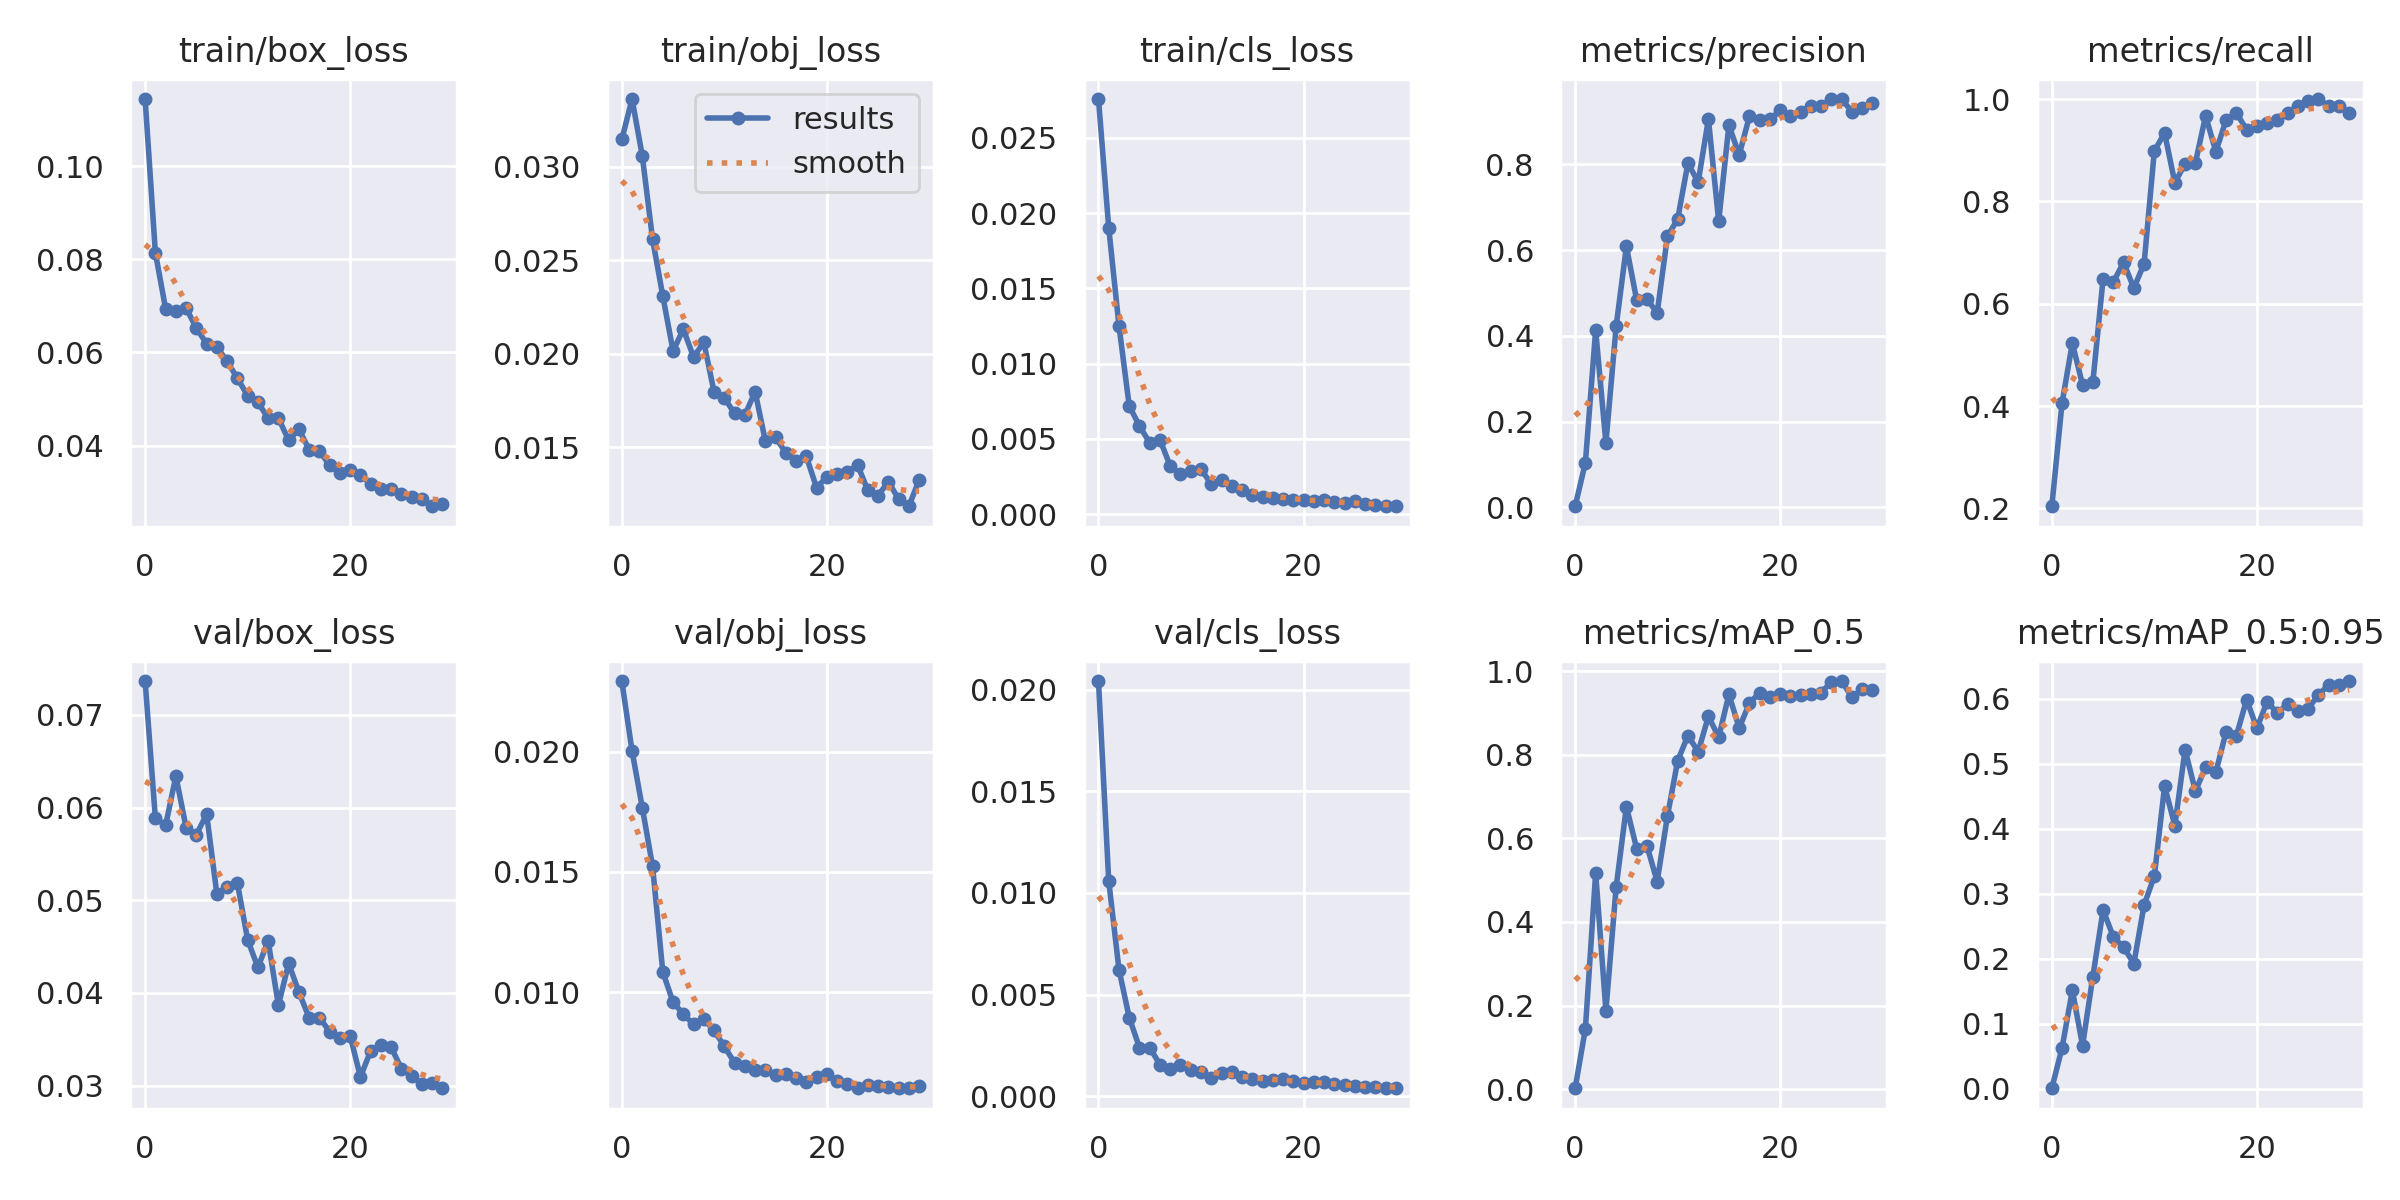

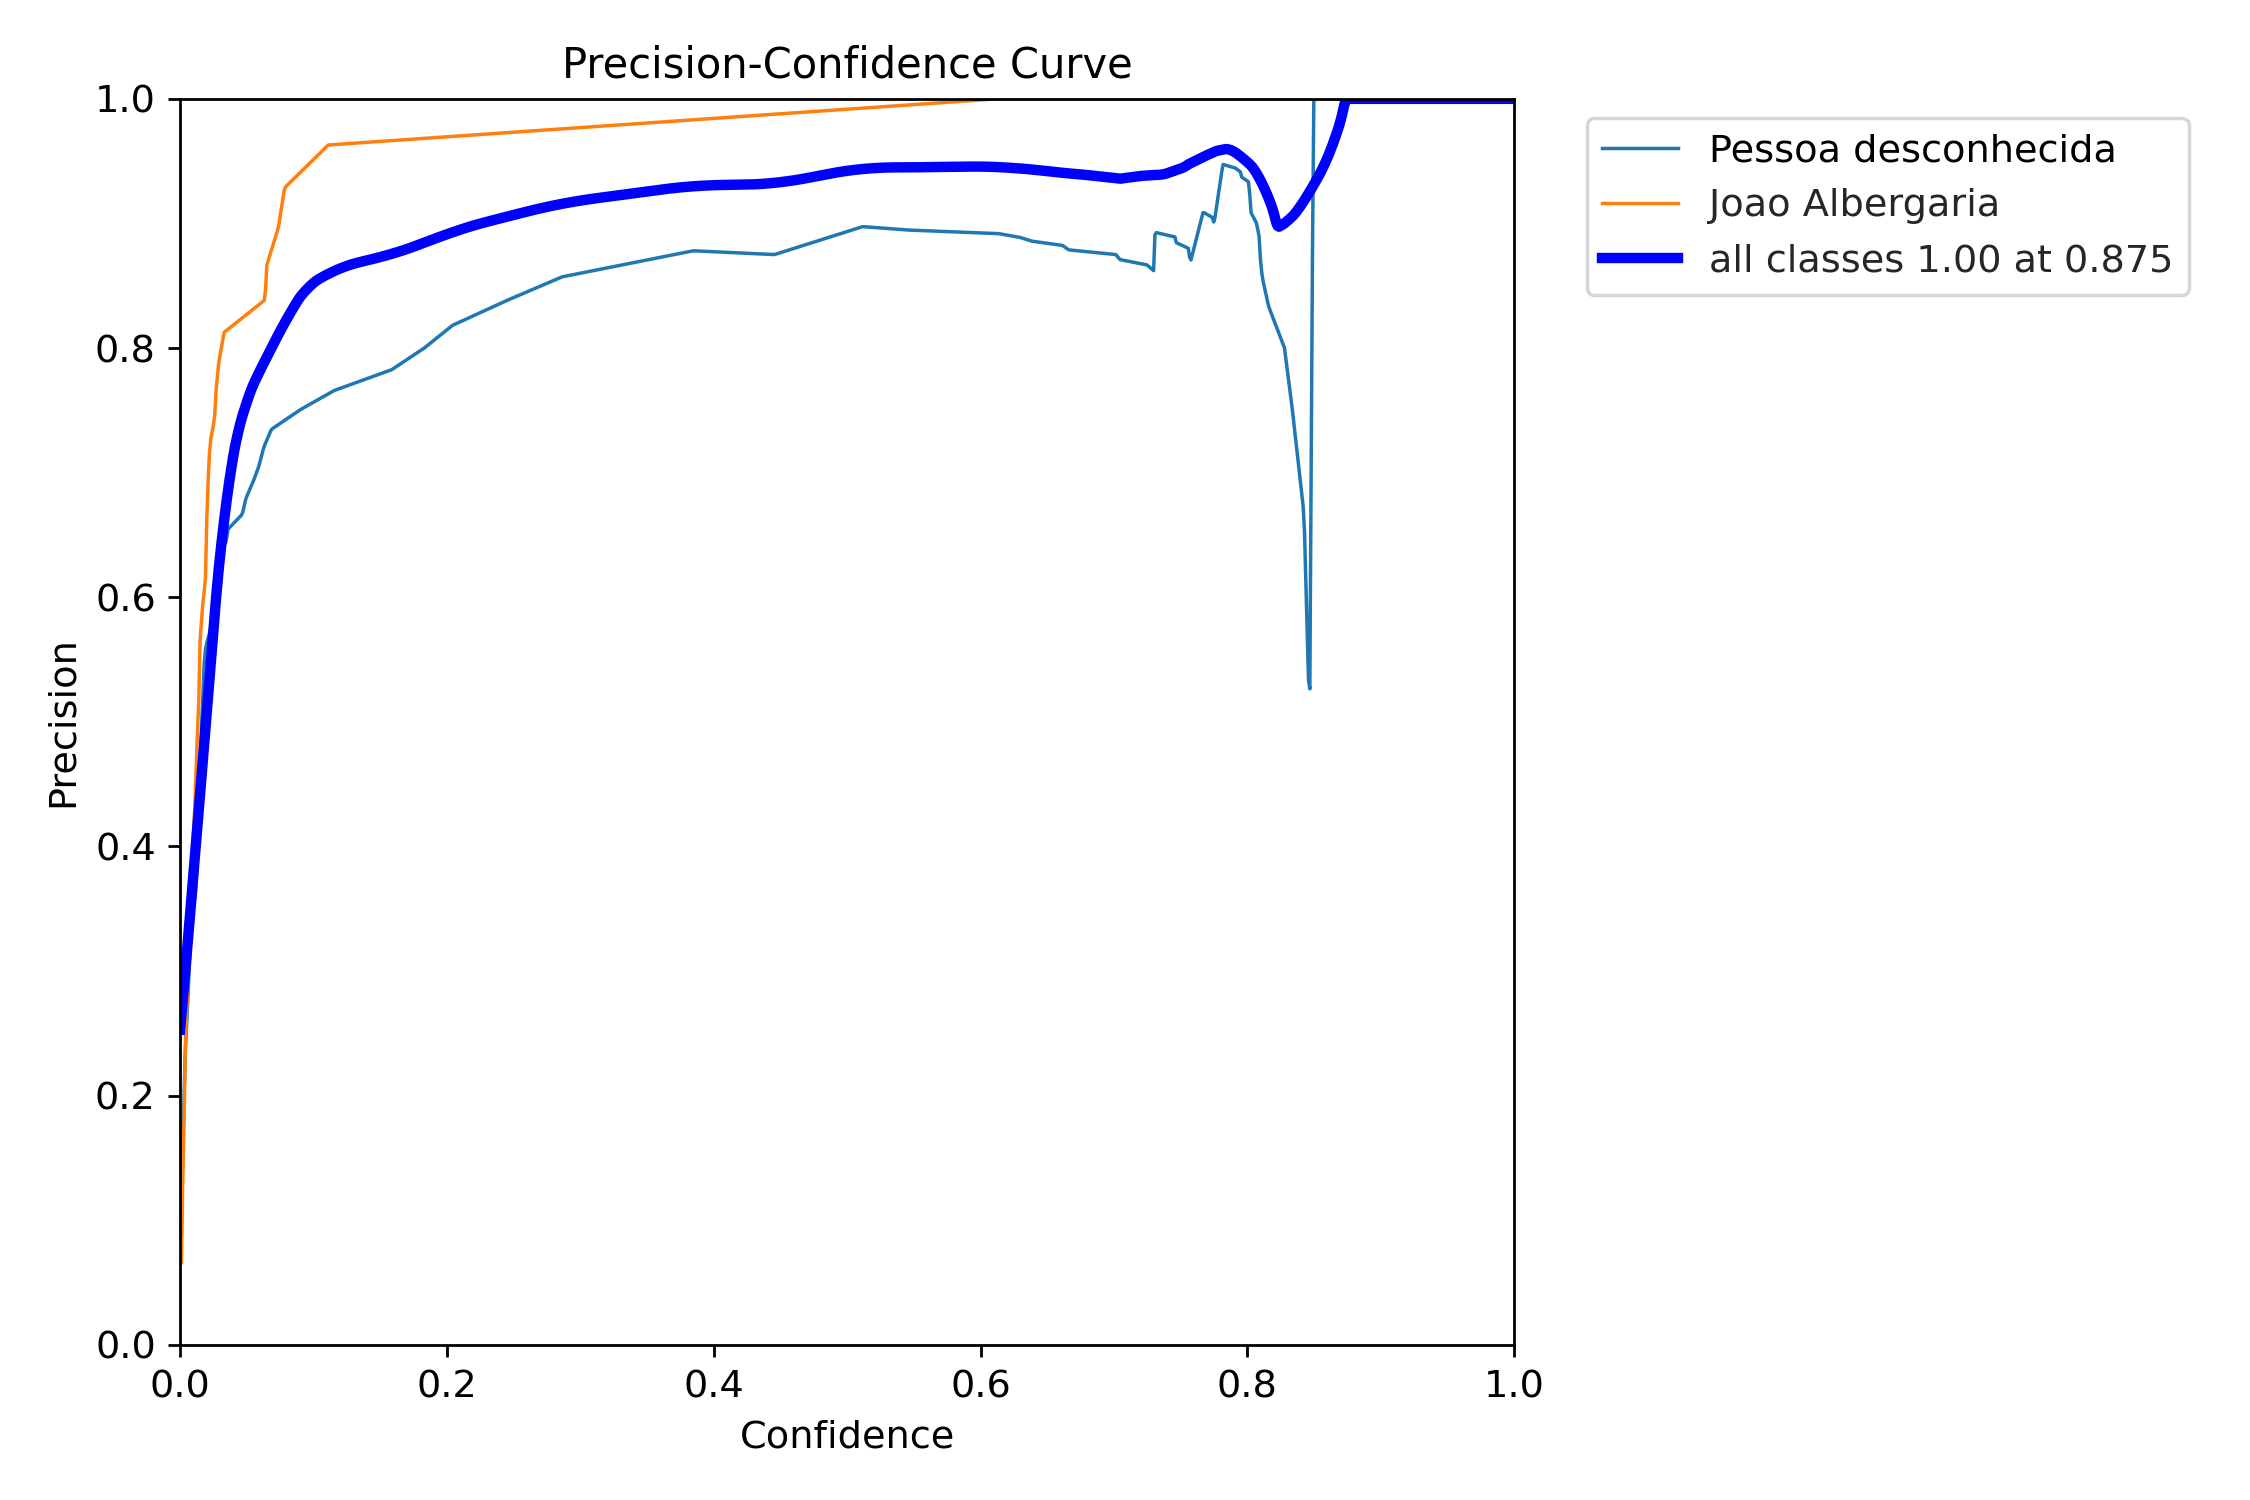

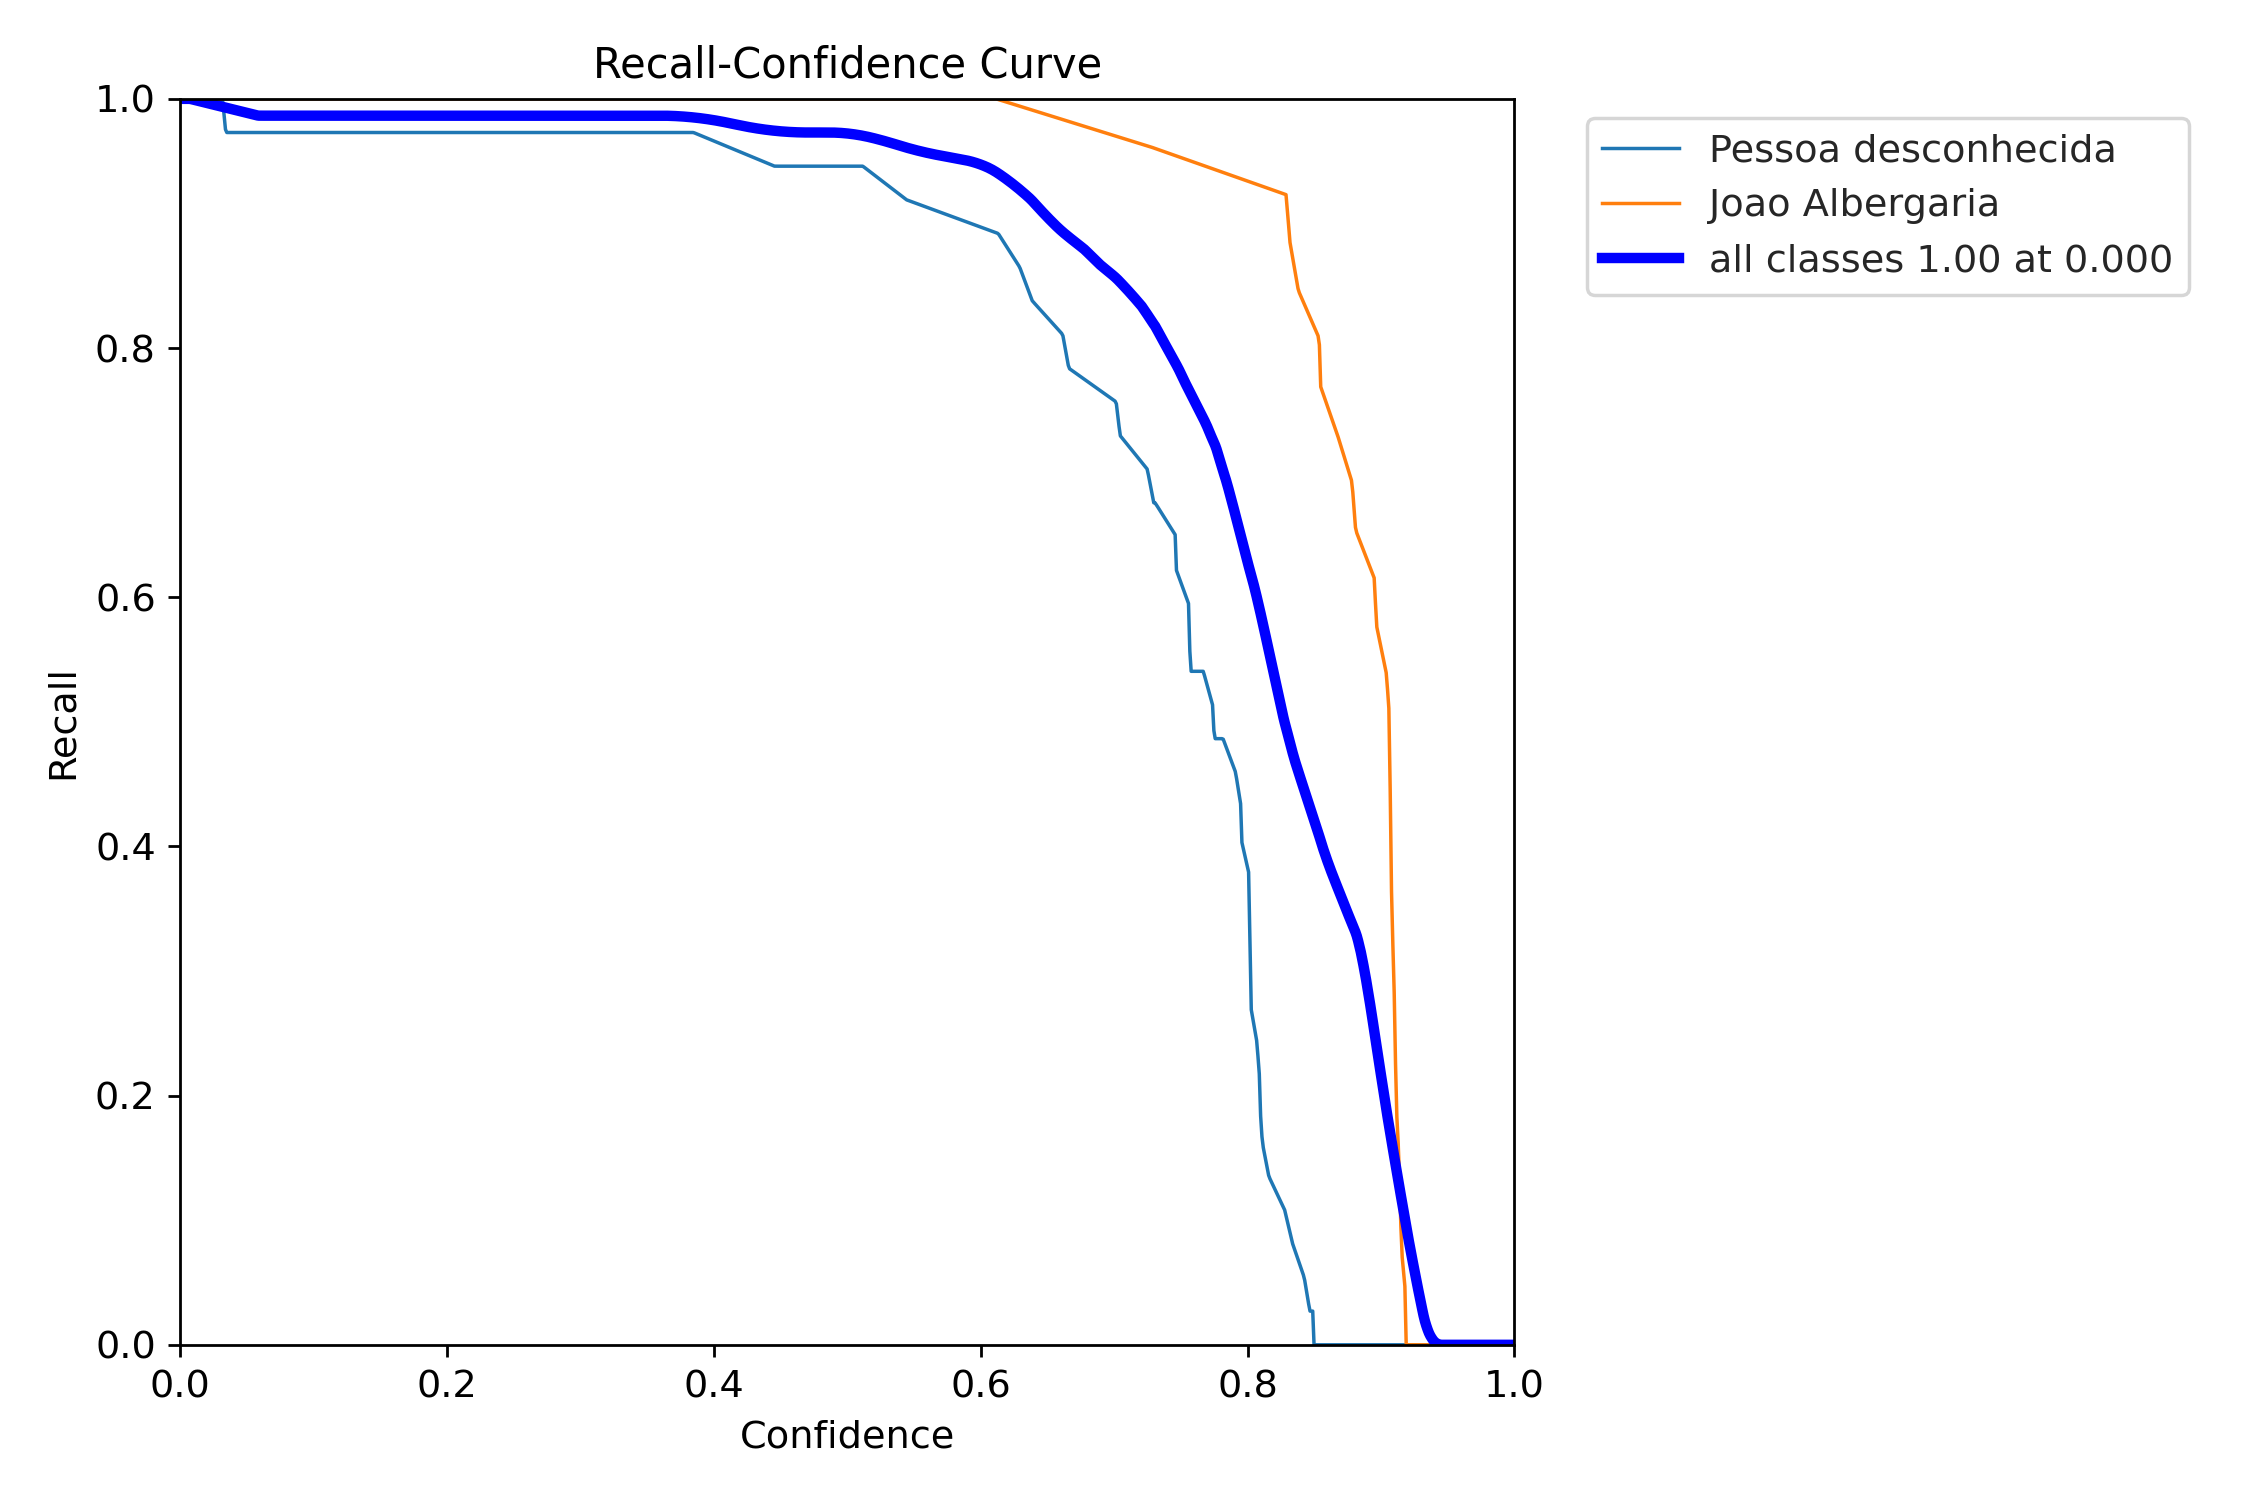

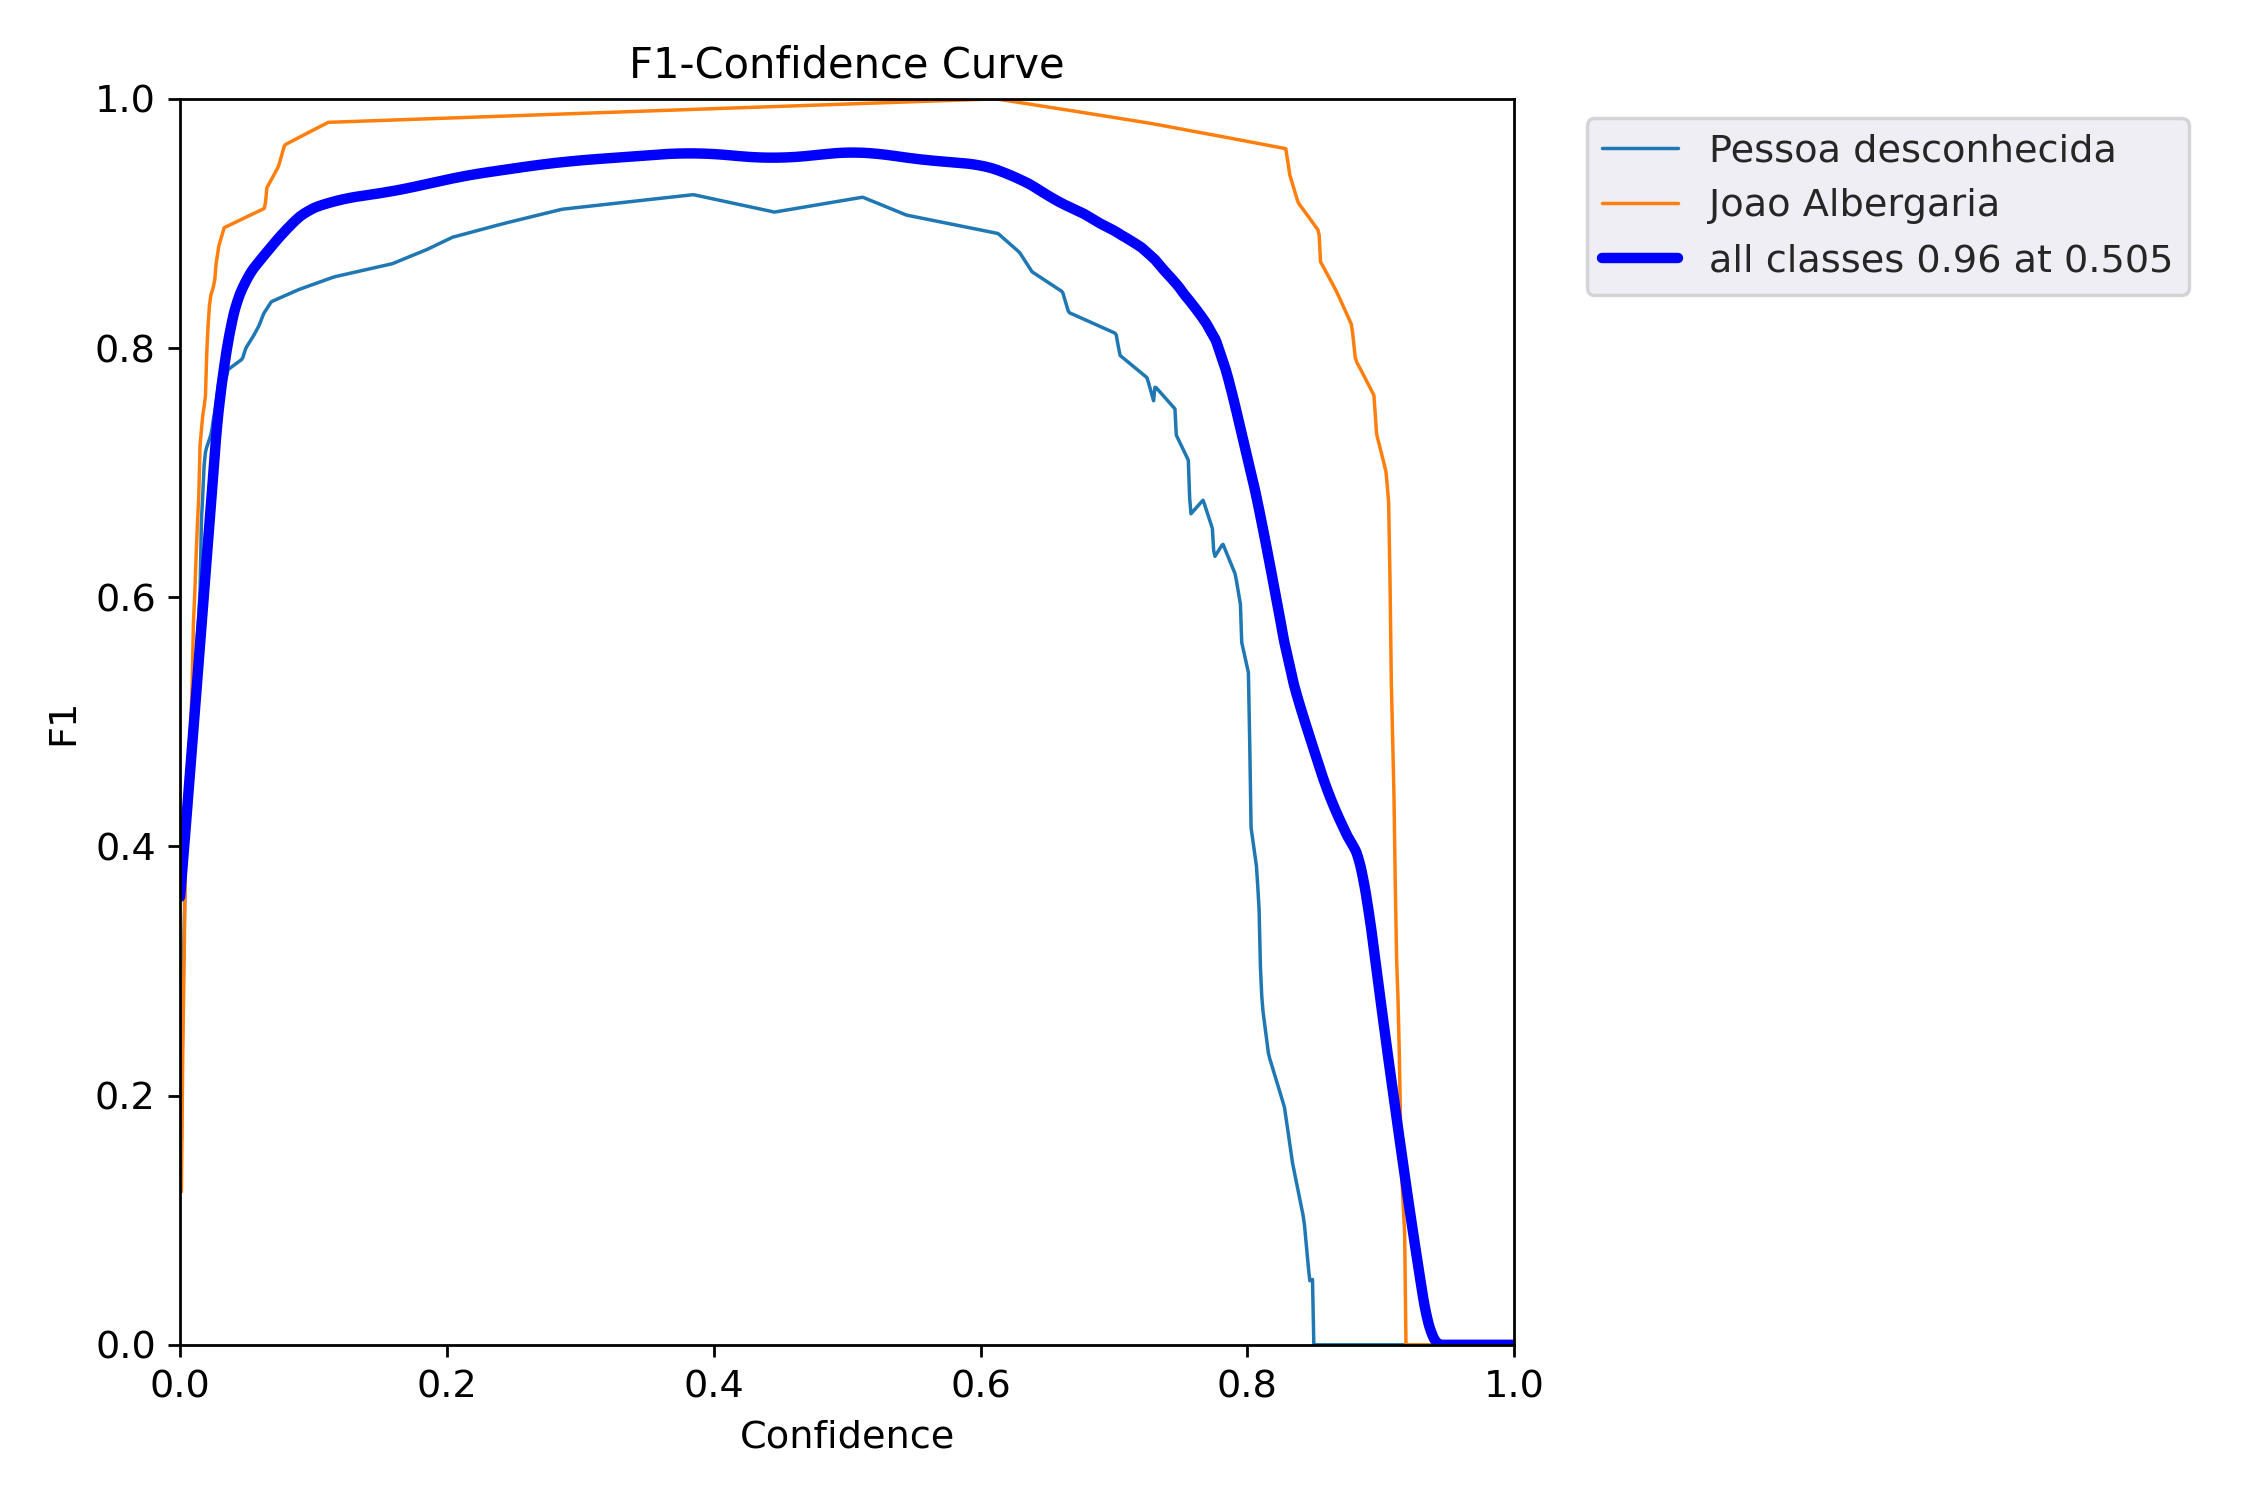

# 5. Testagem dos modelos

## 5.1. Teste do YOLO isolado

Para testar, fizemos a captura da imagem usando a webcam.

Uma vez que o Google Colab não permite vídeo em tempo real, foi usada uma foto.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import PIL.Image
import io
import os

# Aqui, foi preciso usar um trecho de código JavaScript para comunicar com o navegador e conseguir tirar a foto

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Tirar foto';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    //takePhoto({quality: %s});
  ''' % quality)

  display(js)
  data = eval_js("takePhoto()")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

img_path = take_photo()
print(os.path.abspath(img_path))

<IPython.core.display.Javascript object>

/content/yolov5/photo.jpg


Rodando o modelo com a imagem capturada

In [ ]:
# Preferimos usar, aqui, uma linha de comando, porque ela permite maior controle sobre os parâmetros de detecção
!python detect.py \
  --weights /content/modelo_500img-640px.pt \
  --img 640 \
  --conf 0.3\
  --source /content/yolov5/photo.jpg

detect: weights=['/content/modelo_500img-640px.pt'], source=/content/yolov5/photo.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/photo.jpg: 480x640 1 Joao Albergaria, 518.1ms
Speed: 7.8ms pre-process, 518.1ms inference, 1.5ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


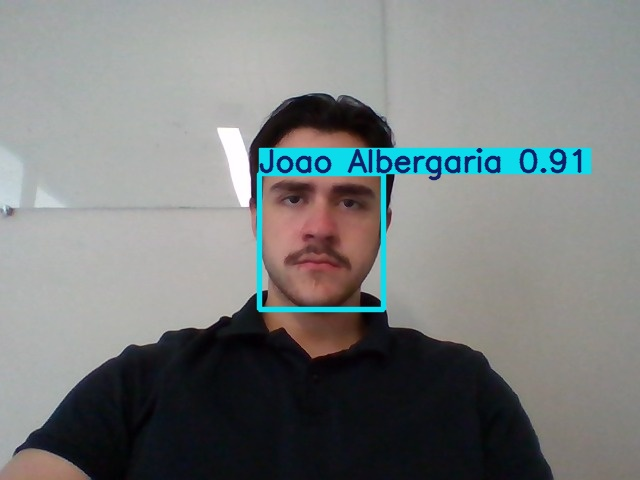

In [ ]:
# Mostrar a imagem com o que foi detectado

from IPython.display import Image, display
import os

# Pasta onde ficam os detects
output_dir = '/content/yolov5/runs/detect/'
latest_exp = sorted(os.listdir(output_dir))[-1]  # Pega a última pasta exp
detected_image_path = os.path.join(output_dir, latest_exp, 'photo.jpg') # Deve ter o mesmo nome da imagem sobre a qual o modelo atuou

display(Image(filename=detected_image_path))

Exemplos de resultados bem-sucedidos (a partir de um modelo treinado com menos épocas apenas para teste):


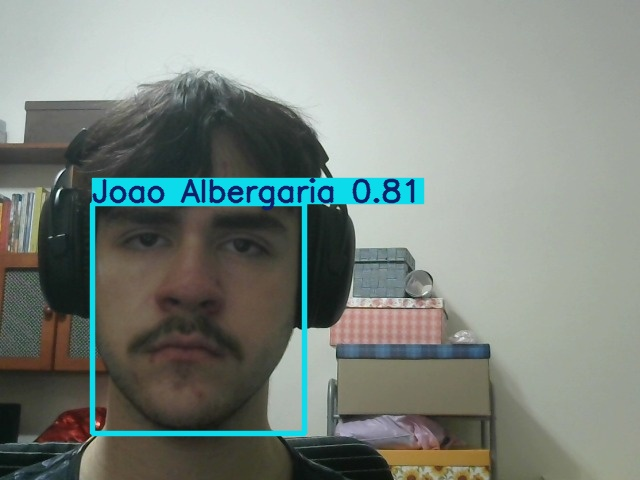

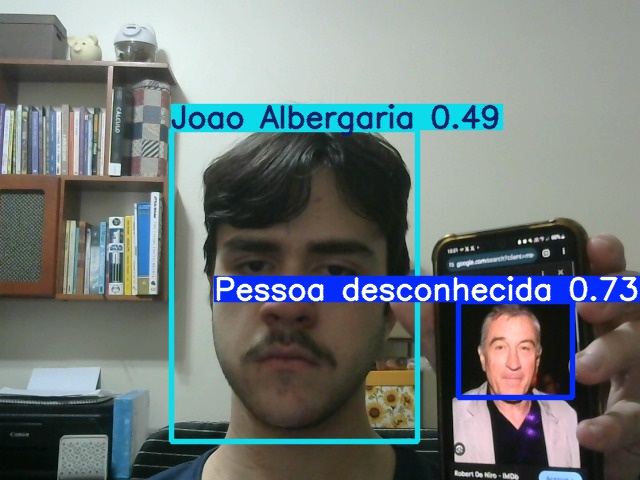

## 5.2. Teste com o DeepFace

Rodando o DeepFace sobre a imagem tirada na câmera:

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-5-19 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


tensor([[177.72049,  97.36022, 462.45276, 317.10843,   0.85672,   0.00000]])
25-05-19 17:24:58 - Found 1 newly added image(s), 1 removed image(s), 0 replaced image(s).


Finding representations: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


25-05-19 17:25:02 - There are now 1 representations in ds_model_vggface_detector_opencv_aligned_normalization_base_expand_0.pkl
25-05-19 17:25:02 - Searching /content/temp_face.jpg in 1 length datastore
25-05-19 17:25:02 - find function duration 4.171245336532593 seconds


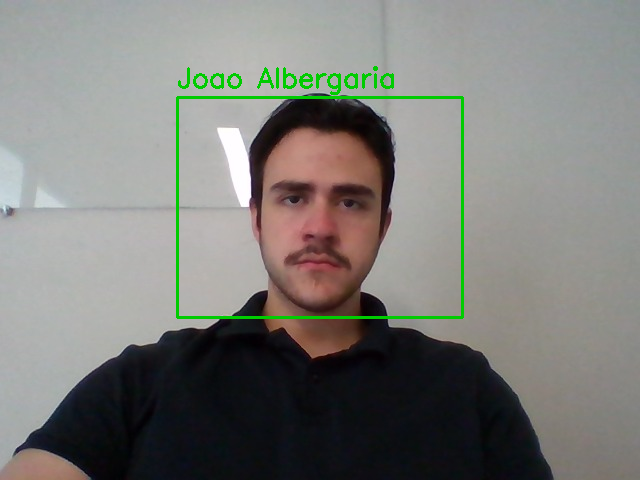

In [ ]:
import cv2
import torch
from deepface import DeepFace
import os

# Carregando o modelo do YOLO
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/modelo_500img-640px.pt', force_reload=True)

# Imagem que queremos detectar
image_path = "/content/yolov5/photo.jpg"
frame = cv2.imread(image_path)
# Detect faces with YOLO
results = model(frame, size=224)
print(results.xyxy[0])

for *box, conf, cls in results.xyxy[0]:
    x1, y1, x2, y2 = map(int, box)

    face_crop = frame[y1:y2, x1:x2]

    # É preciso salvar uma imagem temporária para o DeepFace
    temp_path = "/content/temp_face.jpg"
    cv2.imwrite(temp_path, face_crop)

    try:
        df = DeepFace.find(img_path=temp_path, db_path="/content/faces_db", enforce_detection=False)
        if len(df) > 0 and len(df[0]) > 0:
            label = os.path.basename(df[0].iloc[0]['identity']).replace(".jpg", "")
        else:
            label = "Desconhecido"
    except Exception as e:
        label = "Erro"


    # Mudando a cor baseado no rótulo (se for desconhecido, fica vermelho. Se não, verde)

    if label.lower() == "desconhecido":
        color = (0, 0, 255)
    else:
        color = (0, 204, 0)
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
    # Desenha o retângulo com o rótulo na imagem
    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Mostra o resultado
cv2.imwrite("/content/result.jpg", frame)

from google.colab.patches import cv2_imshow
cv2_imshow(frame)


Aqui, temos o exemplo de uma imagem em que o YOLO por si só não foi capaz de diferenciar o rosto do João, embora o tenha detectado. Ao aplicar o DeepFace, foi possível fazer o reconhecimento facial da forma correta.

Imagem original

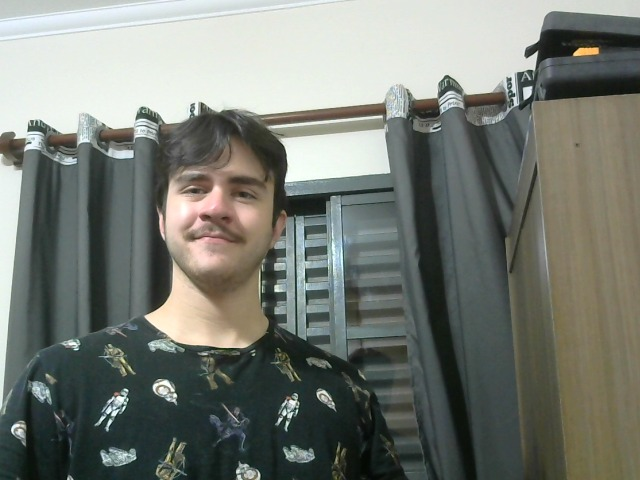

Imagem (como identificada pelo YOLO)

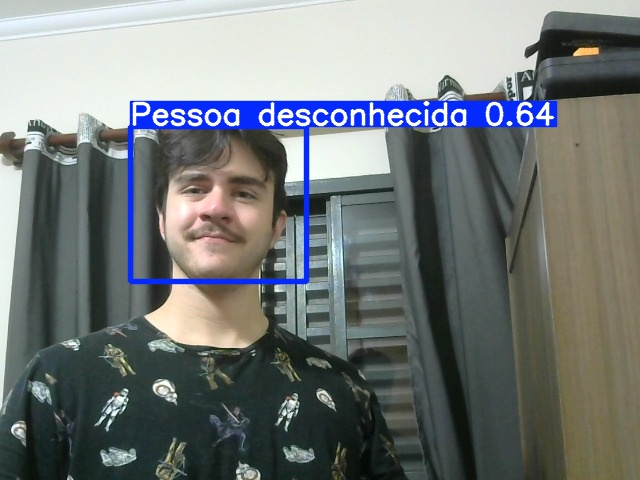

Imagem (YOLO + Deepface)


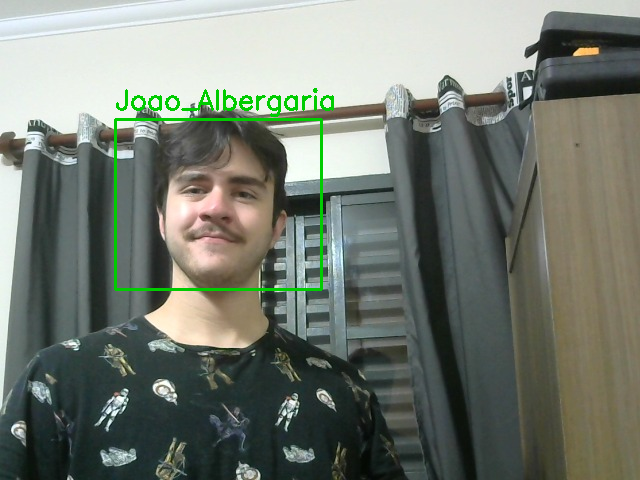

In [2]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\jvalb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
!pip install cv2

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\jvalb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for cv2


In [6]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------------- ---------------------- 0.8/1.8 MB 14.8 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 15.9 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------------------------------------- -- 2.4/2.5 MB 23.8 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 20.0 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable


In [7]:
import torch
import cv2

# Load the model (adjust path if needed)
model = torch.hub.load('ultralytics/yolov5', 'custom', path='mod_teste_.pt', force_reload=True)

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv5 inference
    results = model(frame)

    # Render results on the frame
    results.render()
    cv2.imshow("YOLOv5 Webcam Detection", results.ims[0])

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


ModuleNotFoundError: No module named 'torch'

In [1]:
import cv2
import torch
from yolov5.utils.general import non_max_suppression, scale_boxes
from yolov5.utils.torch_utils import select_device, time_sync
#from yolov5.utils.plots import plot_one_box
import random
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(80)]

# Load model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='modelo_500img-640px.pt', force_reload=True)
device = select_device('0' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# Load video or webcam
cap = cv2.VideoCapture('0')

def plot_one_box(xyxy, img, color=(0, 255, 0), label=None, line_thickness=2):
    """Desenha uma única caixa delimitadora no frame."""
    x1, y1, x2, y2 = [int(c) for c in xyxy]
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=line_thickness)

    if label:
        font_scale = 0.5
        font = cv2.FONT_HERSHEY_SIMPLEX
        thickness = 1
        t_size = cv2.getTextSize(label, font, font_scale, thickness)[0]
        c2 = x1 + t_size[0], y1 - t_size[1] - 3
        cv2.rectangle(img, (x1, y1), c2, color, -1)  # fundo da label
        cv2.putText(img, label, (x1, y1 - 2), font, font_scale, (255, 255, 255), thickness)



while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Inference
    img = torch.from_numpy(frame).to(device)
    img = img.float() / 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    pred = model(img, augment=False)[0]
    pred = non_max_suppression(pred, 0.25, 0.45, classes=None, agnostic=False)

    # Process detections
    for det in pred:
        if len(det):
            det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], frame.shape).round()
            for *xyxy, conf, cls in reversed(det):
                label = f'{model.names[int(cls)]} {conf:.2f}'
                plot_one_box(xyxy, frame, label=label, color=colors[int(cls)], line_thickness=3)

    # Calculate traffic density and queue length
    # Add your custom logic here

    # Display the frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

ModuleNotFoundError: No module named 'utils'

In [10]:
!pip install deepface

Defaulting to user installation because normal site-packages is not writeable
  Using cached deepface-0.0.93-py3-none-any.whl.metadata (30 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
INFO: pip is looking at multiple versions of deepface to determine which version is compatible with other requirements. This could take a while.
  Using cached deepface-0.0.92-py3-none-any.whl.metadata (27 kB)
  Using cached deepface-0.0.91-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.90-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.89-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.88-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.87-py3-none-any.whl.metadata (26 kB)
  Using cached deepface-0.0.86-py3-none-any.whl.metadata (24 kB)
INFO: pip is still looking at multiple versions of deepface to determine which version is compatible with other requirements. This could take a while.
  Using cached deepface-0.0.85-py3-none-any.

ERROR: Cannot install deepface==0.0.1, deepface==0.0.10, deepface==0.0.11, deepface==0.0.12, deepface==0.0.13, deepface==0.0.14, deepface==0.0.15, deepface==0.0.16, deepface==0.0.18, deepface==0.0.19, deepface==0.0.2, deepface==0.0.20, deepface==0.0.21, deepface==0.0.22, deepface==0.0.23, deepface==0.0.24, deepface==0.0.25, deepface==0.0.26, deepface==0.0.3, deepface==0.0.30, deepface==0.0.31, deepface==0.0.32, deepface==0.0.33, deepface==0.0.34, deepface==0.0.35, deepface==0.0.36, deepface==0.0.37, deepface==0.0.38, deepface==0.0.39, deepface==0.0.4, deepface==0.0.40, deepface==0.0.41, deepface==0.0.43, deepface==0.0.44, deepface==0.0.45, deepface==0.0.46, deepface==0.0.47, deepface==0.0.48, deepface==0.0.49, deepface==0.0.5, deepface==0.0.50, deepface==0.0.51, deepface==0.0.52, deepface==0.0.53, deepface==0.0.54, deepface==0.0.55, deepface==0.0.56, deepface==0.0.57, deepface==0.0.58, deepface==0.0.59, deepface==0.0.6, deepface==0.0.60, deepface==0.0.61, deepface==0.0.62, deepface==0.

In [ ]:
import torch
import cv2
import numpy as np
from deepface import DeepFace
from yolov5.models.common import DetectMultiBackend
from yolov5.utils.datasets import LoadImages
from yolov5.utils.general import non_max_suppression, scale_boxes
from yolov5.utils.torch_utils import select_device
import os

# Setup
device = select_device('')  # '' = auto, '0' = GPU
model = DetectMultiBackend('best.pt', device=device)
model.eval()

# Image or video
source = 'photo.jpg'  # ou 'video.mp4'
dataset = LoadImages(source, img_size=640)

# Process frames
for path, img, im0s, vid_cap, s in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.float() / 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    pred = model(img, augment=False)
    pred = non_max_suppression(pred, 0.4, 0.5)

    for det in pred:
        if len(det):
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0s.shape).round()
            for *xyxy, conf, cls in det:
                x1, y1, x2, y2 = map(int, xyxy)
                face_crop = im0s[y1:y2, x1:x2]
                try:
                    result = DeepFace.find(face_crop, db_path="face_database", enforce_detection=False)
                    label = result[0].identity[0].split("/")[-1].split(".")[0] if not result[0].empty else "unknown"
                except:
                    label = "unknown"

                color = (0, 255, 0) if label != "unknown" else (0, 0, 255)
                cv2.rectangle(im0s, (x1, y1), (x2, y2), color, 2)
                cv2.putText(im0s, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Show frame
    cv2.imshow('YOLO + DeepFace', im0s)
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()


In [5]:
pip install --upgrade torch torchvision ultralytics


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\jvalb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
